DeepONet for Navier-Stokes
===========================

Deep Operator Network with branch and trunk networks.
Branch: learns from function values at sensor locations
Trunk: learns coordinate encoding

python deeponet_navier_stokes.py --data_path ./cylinder_nektar_wake.mat \
  --device cuda --seed 0 --test_t_idx 100 --n_sensors 100 \
  --n_query 1000 --hidden_dim 128 --depth 4 --p 100 --steps 1000 \
  --batch_size 32 --lr 1e-3 --save_path checkpoints/deeponet_ns.pt



In [1]:
import os
import math
import argparse
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim=3, hidden_dim=128, 
                 depth=4, p=100, out_dim=3):
        """
        branch_input_dim: number of sensors * channels
        trunk_input_dim: coordinate dimension (x, y, t)
        p: dimension of the inner product space
        out_dim: number of output fields (u, v, p)
        """
        super().__init__()
        self.p = p
        self.out_dim = out_dim
        
        # Branch network (processes sensor data)
        branch_layers = []
        branch_layers.append(nn.Linear(branch_input_dim, hidden_dim))
        branch_layers.append(nn.Tanh())
        for _ in range(depth - 1):
            branch_layers.append(nn.Linear(hidden_dim, hidden_dim))
            branch_layers.append(nn.Tanh())
        branch_layers.append(nn.Linear(hidden_dim, p * out_dim))
        self.branch = nn.Sequential(*branch_layers)
        
        # Trunk network (processes coordinates)
        trunk_layers = []
        trunk_layers.append(nn.Linear(trunk_input_dim, hidden_dim))
        trunk_layers.append(nn.Tanh())
        for _ in range(depth - 1):
            trunk_layers.append(nn.Linear(hidden_dim, hidden_dim))
            trunk_layers.append(nn.Tanh())
        trunk_layers.append(nn.Linear(hidden_dim, p * out_dim))
        self.trunk = nn.Sequential(*trunk_layers)
        
        # Bias
        self.bias = nn.Parameter(torch.zeros(out_dim))
    
    def forward(self, u_sensors, coords):
        """
        u_sensors: (B, n_sensors * channels) - values at sensor locations
        coords: (B, N, 3) - query coordinates (x, y, t)
        Returns: (B, N, out_dim) - predicted fields
        """
        B, N, _ = coords.shape
        
        # Branch network
        branch_out = self.branch(u_sensors)  # (B, p * out_dim)
        branch_out = branch_out.view(B, self.out_dim, self.p)  # (B, out_dim, p)
        
        # Trunk network
        coords_flat = coords.reshape(B * N, -1)
        trunk_out = self.trunk(coords_flat)  # (B*N, p * out_dim)
        trunk_out = trunk_out.view(B, N, self.out_dim, self.p)  # (B, N, out_dim, p)
        
        # Inner product
        out = torch.einsum('bop,bnop->bno', branch_out, trunk_out)
        out = out + self.bias.view(1, 1, -1)
        
        return out


class CylinderWakeData:
    def __init__(self, mat_path, n_sensors=100, seed=0):
        data = scipy.io.loadmat(mat_path)
        self.U_star = data["U_star"]
        self.p_star = data["p_star"]
        self.X_star = data["X_star"]
        self.t_star = data["t"]
        
        self.N = self.X_star.shape[0]
        self.T = self.t_star.shape[0]
        self.n_sensors = n_sensors
        
        # Flatten
        XX = np.tile(self.X_star[:, 0:1], (1, self.T))
        YY = np.tile(self.X_star[:, 1:2], (1, self.T))
        TT = np.tile(self.t_star, (1, self.N)).T
        
        self.x = XX.flatten()[:, None]
        self.y = YY.flatten()[:, None]
        self.t = TT.flatten()[:, None]
        self.u = self.U_star[:, 0, :].flatten()[:, None]
        self.v = self.U_star[:, 1, :].flatten()[:, None]
        self.p = self.p_star.flatten()[:, None]
        
        self.NT = self.x.shape[0]
        self.rng = np.random.RandomState(seed)
        
        # Fixed sensor locations (randomly selected spatial points)
        self.sensor_idx = self.rng.choice(self.N, n_sensors, replace=False)
    
    def get_training_batch(self, batch_size, n_query_per_func):
        """
        Get training batch:
        - Sample batch_size functions (time snapshots)
        - For each function, get sensor values and n_query_per_func query points
        """
        # Sample time indices
        t_indices = self.rng.choice(self.T, batch_size, replace=True)
        
        sensor_vals = []
        query_coords = []
        query_vals = []
        
        for t_idx in t_indices:
            # Sensor values at this time
            u_sensor = self.U_star[self.sensor_idx, 0, t_idx]
            v_sensor = self.U_star[self.sensor_idx, 1, t_idx]
            p_sensor = self.p_star[self.sensor_idx, t_idx]
            sensors = np.concatenate([u_sensor, v_sensor, p_sensor])
            sensor_vals.append(sensors)
            
            # Query points (random spatial locations at this time)
            query_idx = self.rng.choice(self.N, n_query_per_func, replace=False)
            x_q = self.X_star[query_idx, 0:1]
            y_q = self.X_star[query_idx, 1:2]
            t_q = np.full_like(x_q, self.t_star[t_idx, 0])
            coords = np.concatenate([x_q, y_q, t_q], axis=1)
            query_coords.append(coords)
            
            u_q = self.U_star[query_idx, 0, t_idx:t_idx+1]
            v_q = self.U_star[query_idx, 1, t_idx:t_idx+1]
            p_q = self.p_star[query_idx, t_idx:t_idx+1]
            vals = np.concatenate([u_q, v_q, p_q], axis=1)
            query_vals.append(vals)
        
        return (np.array(sensor_vals), 
                np.array(query_coords),
                np.array(query_vals))
    
    def get_snapshot(self, t_idx):
        """Get full snapshot for evaluation"""
        # Sensor values
        u_sensor = self.U_star[self.sensor_idx, 0, t_idx]
        v_sensor = self.U_star[self.sensor_idx, 1, t_idx]
        p_sensor = self.p_star[self.sensor_idx, t_idx]
        sensors = np.concatenate([u_sensor, v_sensor, p_sensor])
        
        # All spatial points at this time
        x = self.X_star[:, 0:1]
        y = self.X_star[:, 1:2]
        t = np.full_like(x, self.t_star[t_idx, 0])
        coords = np.concatenate([x, y, t], axis=1)
        
        u = self.U_star[:, 0, t_idx:t_idx+1]
        v = self.U_star[:, 1, t_idx:t_idx+1]
        p = self.p_star[:, t_idx:t_idx+1]
        vals = np.concatenate([u, v, p], axis=1)
        
        return sensors, coords, vals


In [3]:
def plot_results(res, history, args, save_dir):
    """Create comprehensive result plots for DeepONet"""
    os.makedirs(save_dir, exist_ok=True)
    
    # 1. Training curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    ax = axes[0]
    ax.semilogy(history["step"], history["train_loss"])
    ax.set_title("Training Loss")
    ax.set_xlabel("Step")
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    ax.semilogy(history["step"], history["test_mse"])
    ax.set_title("Test MSE")
    ax.set_xlabel("Step")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    # 2. Prediction visualization
    x = res["x"]
    y = res["y"]
    uvp_true = res["uvp_true"]
    uvp_pred = res["uvp_pred"]
    
    # Detect grid structure
    xu = np.unique(np.round(x, 10))
    yu = np.unique(np.round(y, 10))
    nx, ny = len(xu), len(yu)
    
    try:
        x_to_i = {val: i for i, val in enumerate(xu)}
        y_to_j = {val: j for j, val in enumerate(yu)}
        
        def to_grid(values):
            grid = np.full((ny, nx), np.nan)
            for xi, yi, val in zip(np.round(x, 10), np.round(y, 10), values):
                grid[y_to_j[yi], x_to_i[xi]] = val
            return grid
        
        is_grid = True
    except:
        is_grid = False
    
    fig, axes = plt.subplots(3, 3, figsize=(14, 10))
    
    for i, var in enumerate(['u', 'v', 'p']):
        true_val = uvp_true[:, i]
        pred_val = uvp_pred[:, i]
        err_val = np.abs(pred_val - true_val)
        
        if is_grid:
            true_grid = to_grid(true_val)
            pred_grid = to_grid(pred_val)
            err_grid = to_grid(err_val)
            extent = [xu.min(), xu.max(), yu.min(), yu.max()]
            
            ax = axes[i, 0]
            im = ax.imshow(true_grid, origin='lower', aspect='auto', 
                          extent=extent, cmap='viridis', interpolation='bilinear')
            ax.set_title(f'{var} (True)')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            plt.colorbar(im, ax=ax)
            
            ax = axes[i, 1]
            im = ax.imshow(pred_grid, origin='lower', aspect='auto',
                          extent=extent, cmap='viridis', interpolation='bilinear')
            ax.set_title(f'{var} (Pred)')
            ax.set_xlabel('x')
            plt.colorbar(im, ax=ax)
            
            ax = axes[i, 2]
            im = ax.imshow(err_grid, origin='lower', aspect='auto',
                          extent=extent, cmap='hot', interpolation='bilinear')
            ax.set_title(f'{var} (Abs Error)')
            ax.set_xlabel('x')
            plt.colorbar(im, ax=ax)
        else:
            ax = axes[i, 0]
            sc = ax.scatter(x, y, c=true_val, s=3, cmap='viridis')
            ax.set_title(f'{var} (True)')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            plt.colorbar(sc, ax=ax)
            
            ax = axes[i, 1]
            sc = ax.scatter(x, y, c=pred_val, s=3, cmap='viridis')
            ax.set_title(f'{var} (Pred)')
            ax.set_xlabel('x')
            plt.colorbar(sc, ax=ax)
            
            ax = axes[i, 2]
            sc = ax.scatter(x, y, c=err_val, s=3, cmap='hot')
            ax.set_title(f'{var} (Abs Error)')
            ax.set_xlabel('x')
            plt.colorbar(sc, ax=ax)
    
    plt.suptitle(f"DeepONet | MSE={res['mse']:.3e} | t_index={args.test_t_idx}", y=0.995)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'predictions.png'), dpi=150, bbox_inches='tight')
    
    print(f"Saved plots to {save_dir}/")

In [4]:
def train_deeponet(args):
    device = torch.device(args.device)
    set_seed(args.seed)
    
    data = CylinderWakeData(args.data_path, n_sensors=args.n_sensors, seed=args.seed)
    
    # Model
    branch_input_dim = args.n_sensors * 3  # 3 channels: u, v, p
    model = DeepONet(branch_input_dim=branch_input_dim,
                     trunk_input_dim=3,
                     hidden_dim=args.hidden_dim,
                     depth=args.depth,
                     p=args.p,
                     out_dim=3).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
                                 weight_decay=args.weight_decay)
    
    n_params = sum(p.numel() for p in model.parameters())
    print(f"\nDeepONet Training")
    print(f"Device: {device}")
    print(f"Parameters: {n_params:,}")
    print(f"Sensors: {args.n_sensors}")
    print(f"Inner product dim (p): {args.p}")
    print(f"Test snapshot: t_idx={args.test_t_idx}")
    
    # Get test data
    test_sensors, test_coords, test_vals = data.get_snapshot(args.test_t_idx)
    test_sensors = torch.tensor(test_sensors, dtype=torch.float32, 
                               device=device).unsqueeze(0)
    test_coords = torch.tensor(test_coords, dtype=torch.float32, 
                              device=device).unsqueeze(0)
    test_vals = torch.tensor(test_vals, dtype=torch.float32, device=device)
    
    history = {"step": [], "train_loss": [], "test_mse": []}
    best_test = float('inf')
    
    for step in range(1, args.steps + 1):
        model.train()
        optimizer.zero_grad()
        
        # Get training batch
        sensors, coords, vals = data.get_training_batch(args.batch_size, 
                                                        args.n_query)
        sensors = torch.tensor(sensors, dtype=torch.float32, device=device)
        coords = torch.tensor(coords, dtype=torch.float32, device=device)
        vals = torch.tensor(vals, dtype=torch.float32, device=device)
        
        # Forward
        pred = model(sensors, coords)
        loss = F.mse_loss(pred, vals)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if step % args.print_every == 0 or step == 1:
            model.eval()
            with torch.no_grad():
                pred_test = model(test_sensors, test_coords).squeeze(0)
                test_mse = F.mse_loss(pred_test, test_vals).item()
            
            print(f"[{step:06d}] train_loss={loss.item():.3e} | "
                  f"test_mse={test_mse:.3e}")
            
            history["step"].append(step)
            history["train_loss"].append(loss.item())
            history["test_mse"].append(test_mse)
            
            if test_mse < best_test:
                best_test = test_mse
                if args.save_path:
                    os.makedirs(os.path.dirname(args.save_path), exist_ok=True)
                    torch.save({
                        'model': model.state_dict(),
                        'step': step,
                        'test_mse': best_test,
                        'history': history,
                    }, args.save_path)
    
    print(f"\nBest test MSE: {best_test:.3e}")
    
    # Final evaluation and plotting
    model.eval()
    with torch.no_grad():
        pred_test = model(test_sensors, test_coords).squeeze(0)
    
    res = {
        'x': test_coords.squeeze(0)[:, 0].cpu().numpy(),
        'y': test_coords.squeeze(0)[:, 1].cpu().numpy(),
        'uvp_true': test_vals.cpu().numpy(),
        'uvp_pred': pred_test.cpu().numpy(),
        'mse': best_test
    }
    
    save_dir = os.path.join(os.path.dirname(args.save_path), 'deeponet_plots')
    plot_results(res, history, args, save_dir)
    
    return model, history


DeepONet Training
Device: cpu
Parameters: 1,137,115
Sensors: 2500
Inner product dim (p): 100
Test snapshot: t_idx=100
[000001] train_loss=2.931e-01 | test_mse=6.646e-02
[000500] train_loss=2.891e-02 | test_mse=2.849e-02
[001000] train_loss=2.458e-02 | test_mse=2.428e-02
[001500] train_loss=1.860e-02 | test_mse=1.824e-02
[002000] train_loss=2.358e-02 | test_mse=2.485e-02
[002500] train_loss=1.532e-02 | test_mse=1.350e-02
[003000] train_loss=1.543e-02 | test_mse=2.052e-02
[003500] train_loss=1.387e-02 | test_mse=1.153e-02
[004000] train_loss=1.247e-02 | test_mse=9.007e-03
[004500] train_loss=1.151e-02 | test_mse=7.178e-03
[005000] train_loss=1.749e-02 | test_mse=1.103e-02

Best test MSE: 7.178e-03
Saved plots to checkpoints\deeponet_plots/


(DeepONet(
   (branch): Sequential(
     (0): Linear(in_features=7500, out_features=128, bias=True)
     (1): Tanh()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): Tanh()
     (4): Linear(in_features=128, out_features=128, bias=True)
     (5): Tanh()
     (6): Linear(in_features=128, out_features=128, bias=True)
     (7): Tanh()
     (8): Linear(in_features=128, out_features=300, bias=True)
   )
   (trunk): Sequential(
     (0): Linear(in_features=3, out_features=128, bias=True)
     (1): Tanh()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): Tanh()
     (4): Linear(in_features=128, out_features=128, bias=True)
     (5): Tanh()
     (6): Linear(in_features=128, out_features=128, bias=True)
     (7): Tanh()
     (8): Linear(in_features=128, out_features=300, bias=True)
   )
 ),
 {'step': [1, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
  'train_loss': [0.2930551767349243,
   0.028911953791975975,
   0.024578692391514778,


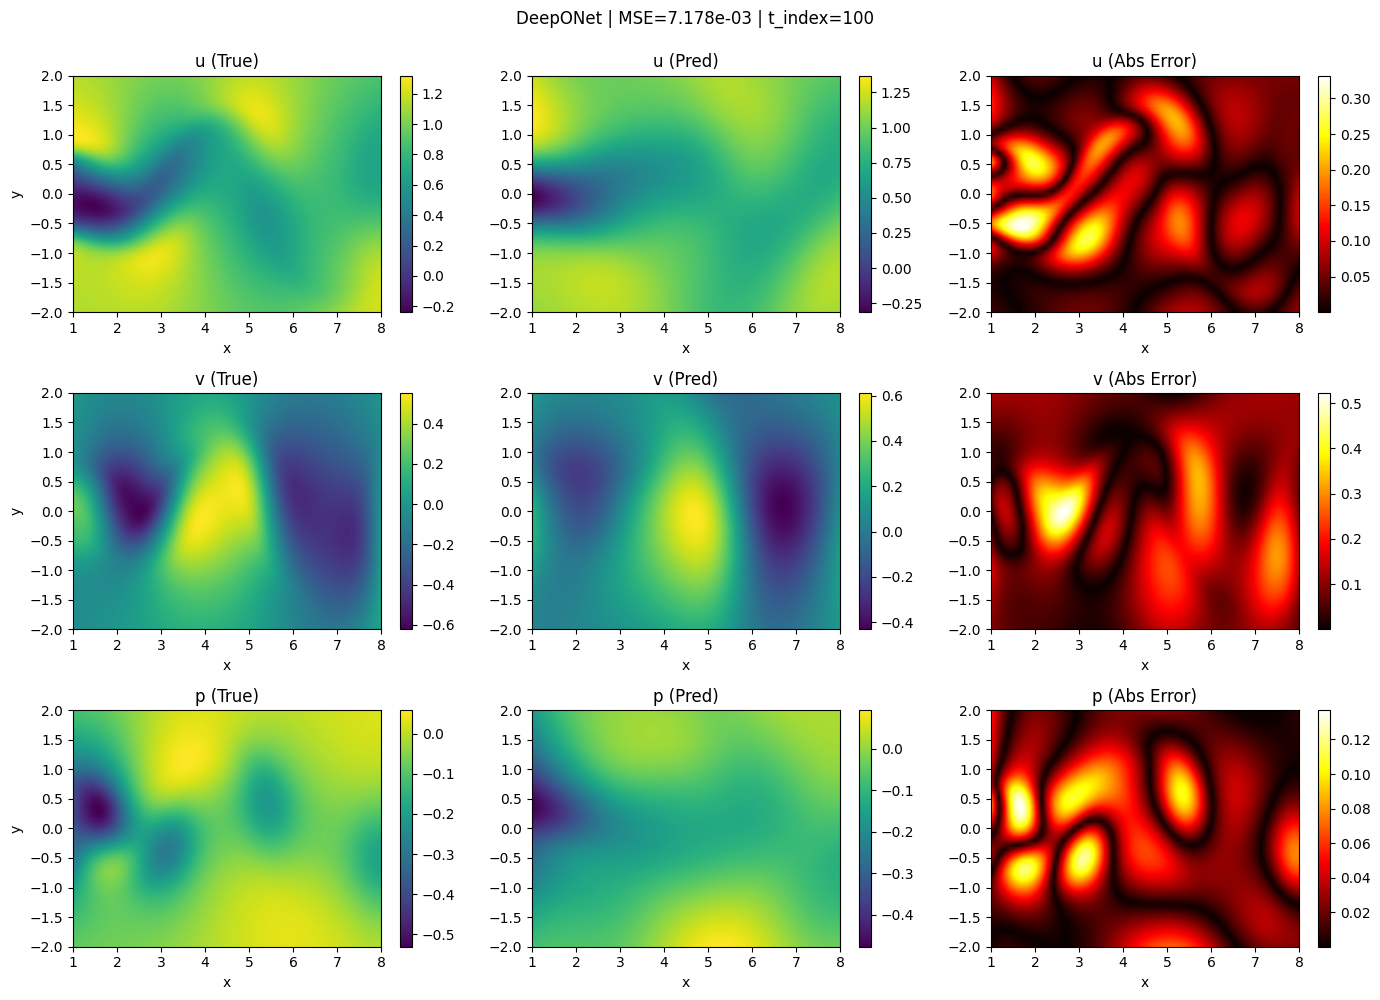

In [9]:
class Config:
    data_path = "./cylinder_nektar_wake.mat"
    device = "cpu"
    seed = 0
    n_sensors = 2500
    n_query = 1000
    test_t_idx = 100
    hidden_dim = 128
    depth = 4
    p = 100
    steps = 5000
    batch_size = 32
    lr = 1e-3
    weight_decay = 1e-4
    print_every = 500
    save_path = "checkpoints/deeponet_ns.pt"
    
args = Config()



train_deeponet(args)